In [2]:
import os
import glob
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyecharts import WordCloud, Bar
%matplotlib inline

### Get the files -> 2015,2016,2017(as of October) Crime log

In [3]:
files = glob.glob("d*")
content = []

### Join all the files into a single file 

In [4]:
for i in files:
    df = pd.read_excel(i, index_col=None)
    content.append(df)
    
df = pd.concat(content)

In [5]:
df.head(3)

,Case Number,Classification,Date/Time Reported,Earliest Occurrence,Latest Occurrence,General Location,Disposition
0,15-000001,License Violation,01/01/15 0008,01/01/15 0008,01/01/15 0008,2700 block of Knapp Street,Arrest
1,15-000002,Operating While Intoxicated,01/01/15 0106,01/01/15 0106,01/01/15 0106,Beach Avenue and Lincoln Way,Arrest
2,15-000002,Alcohol Violation,01/01/15 0106,01/01/15 0106,01/01/15 0106,Beach Avenue and Lincoln Way,Arrest


In [6]:
df.describe()

,Case Number,Classification,Date/Time Reported,Earliest Occurrence,Latest Occurrence,General Location,Disposition
count,3579,3582,3582,2419,3561,3582,3582
unique,3274,97,3251,2095,3235,807,11
top,15-000263,Theft,02/28/15 2131,10/05/17 0000,11/30/16 0907,Armory Building,Arrest
freq,5,729,5,8,5,235,2131


## Check for duplicates and missing values in rows

In [7]:
df[df.duplicated]

,Case Number,Classification,Date/Time Reported,Earliest Occurrence,Latest Occurrence,General Location,Disposition


In [8]:
# df[df.isnull().any(axis=1)]

There are no duplicates which is good and about 1157 rows with missing Earliest Occurance which i will ignore for now.

### Rename columns for easy reference 

In [9]:
col = {i:i.replace(" ","_").replace("/","_") for i in df.columns.values}
df = df.rename(index=str, columns=col)

### Extract months, day and time of the day  from date into it own column

In [10]:
# # convert to Y_M_D
df.Earliest_Occurrence = pd.to_datetime(df["Earliest_Occurrence"]).dt.strftime("%Y-%m-%d")
df.Latest_Occurrence = pd.to_datetime(df["Latest_Occurrence"]).dt.strftime("%Y-%m-%d")

#set year reported
df.insert(3,"Year_Reported", pd.to_datetime(df.Date_Time_Reported).dt.year)

#set month
df.insert(3,"Month_Reported",pd.to_datetime(df["Date_Time_Reported"]).dt.month.apply(lambda x:calendar.month_name[x]))

#set time
df.insert(3,"Time_Reported",pd.to_datetime(df["Date_Time_Reported"]).dt.strftime("%H:%M"))


In [11]:
df.head(3)

,Case_Number,Classification,Date_Time_Reported,Time_Reported,Month_Reported,Year_Reported,Earliest_Occurrence,Latest_Occurrence,General_Location,Disposition
0,15-000001,License Violation,01/01/15 0008,00:08,January,2015,2015-01-01,2015-01-01,2700 block of Knapp Street,Arrest
1,15-000002,Operating While Intoxicated,01/01/15 0106,01:06,January,2015,2015-01-01,2015-01-01,Beach Avenue and Lincoln Way,Arrest
2,15-000002,Alcohol Violation,01/01/15 0106,01:06,January,2015,2015-01-01,2015-01-01,Beach Avenue and Lincoln Way,Arrest


#### For the purpose of this analysis we are interested in the type of crime, its frequency and the locations that happen. For that reason, I will extract those columns into thier own data frame.

In [12]:
# both works the same
#df.iloc[:,[0,1,2,3,4,5,8,9]]
crime_report = df.drop(df.columns[[6,7]], axis=1)

In [13]:
crime_report.head(3)

,Case_Number,Classification,Date_Time_Reported,Time_Reported,Month_Reported,Year_Reported,General_Location,Disposition
0,15-000001,License Violation,01/01/15 0008,00:08,January,2015,2700 block of Knapp Street,Arrest
1,15-000002,Operating While Intoxicated,01/01/15 0106,01:06,January,2015,Beach Avenue and Lincoln Way,Arrest
2,15-000002,Alcohol Violation,01/01/15 0106,01:06,January,2015,Beach Avenue and Lincoln Way,Arrest


## Which month by year has most crime been reported. 

In [14]:
crime_report.groupby(["Year_Reported","Month_Reported"]).count().Disposition.unstack()

Month_Reported,April,August,December,February,January,July,June,March,May,November,October,September
Year_Reported,,,,,,,,,,,,
2015,144.0,89.0,73.0,84.0,86.0,57.0,53.0,77.0,85.0,110.0,184.0,193.0
2016,133.0,113.0,53.0,111.0,82.0,58.0,65.0,86.0,76.0,120.0,155.0,244.0
2017,99.0,115.0,NaN,85.0,69.0,65.0,43.0,103.0,63.0,NaN,110.0,299.0


## What are the open cases and arrest in each month

In [15]:
vis_open_arrest = crime_report[(crime_report.Disposition == "Arrest") | (crime_report.Disposition == "Open")]

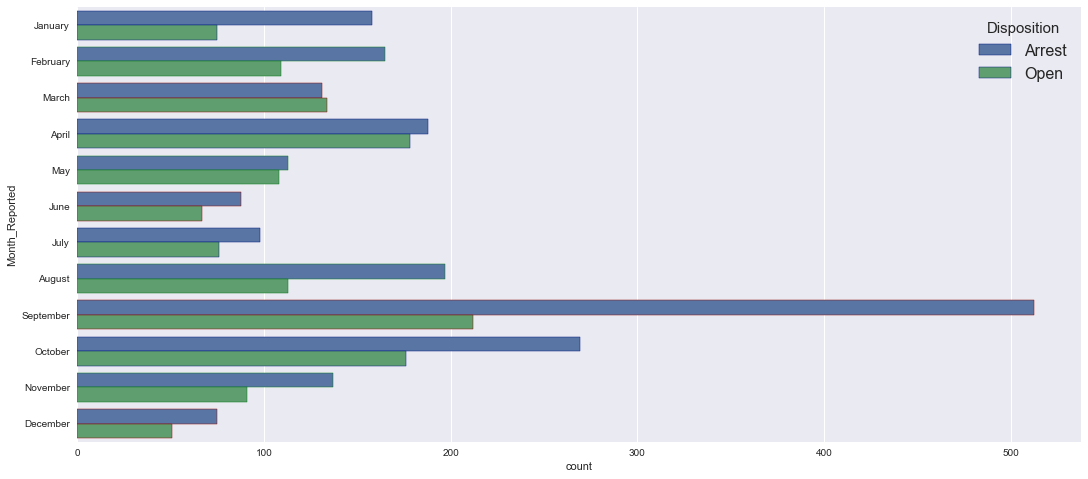

In [16]:
f, ax = plt.subplots(figsize=(18,8))
sns.set_style("whitegrid")
sns.set_context("poster")
sns.countplot(data=vis_open_arrest,y="Month_Reported", hue="Disposition",edgecolor=sns.color_palette("dark", 3),ax=ax)

## Visualization of Open and Arrest cases for each month and each year

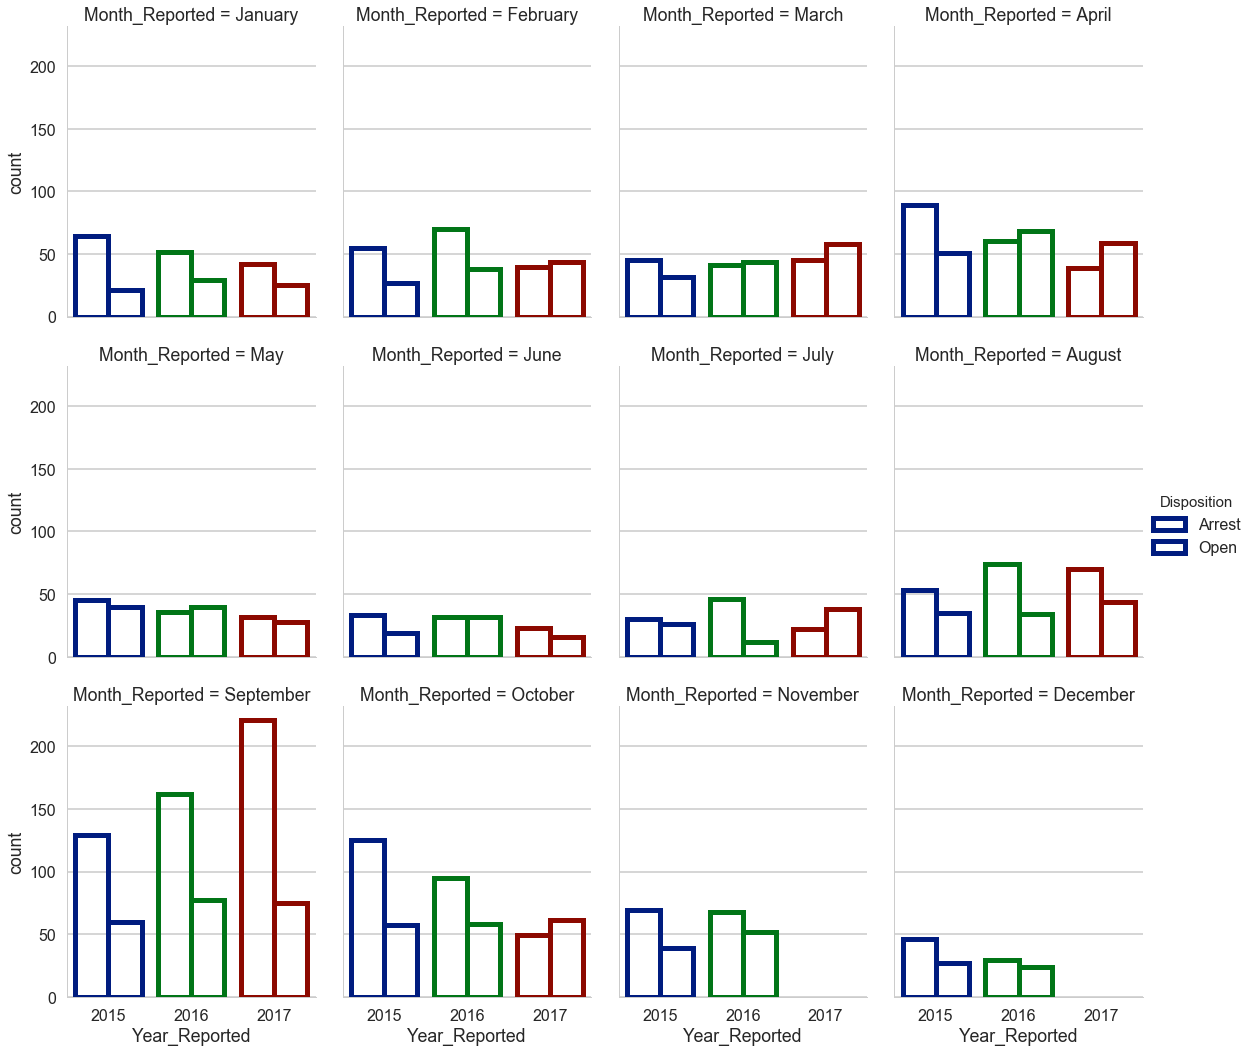

In [17]:
#plt.figure(figsize=(20,10))
sns.factorplot(x="Year_Reported", hue="Disposition", col="Month_Reported",
               data=vis_open_arrest, kind="count",col_wrap=4,facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3),
               size=5, aspect=.8,legend=True)

From the table and graph above we can see that september has the most crime reports for the past three years and it keeps increase as compared to the other months. Also remenber that data for __2017__ goes till August. For that reason I will forcus my analysis a little bit on September. That does mean the other Months are not necessary to study, but I just want to narrow the anlysis as of now.

I will go ahead and add a columns of called Day_of_Month. This is help us identity the day of the week which has most arrest.

In [18]:
crime_report.insert(3,"Day_of_Month",pd.to_datetime(crime_report.Date_Time_Reported).dt.weekday_name)

In [19]:
crime_report.head(3)

,Case_Number,Classification,Date_Time_Reported,Day_of_Month,Time_Reported,Month_Reported,Year_Reported,General_Location,Disposition
0,15-000001,License Violation,01/01/15 0008,Thursday,00:08,January,2015,2700 block of Knapp Street,Arrest
1,15-000002,Operating While Intoxicated,01/01/15 0106,Thursday,01:06,January,2015,Beach Avenue and Lincoln Way,Arrest
2,15-000002,Alcohol Violation,01/01/15 0106,Thursday,01:06,January,2015,Beach Avenue and Lincoln Way,Arrest


Since we are concentrating on September, lets check to see which day of the week do these crimes happen.

In [20]:
crime_report[crime_report.Month_Reported == "September"].Day_of_Month.value_counts()

Saturday     370
Thursday      91
Friday        81
Sunday        67
Monday        48
Wednesday     44
Tuesday       35
Name: Day_of_Month, dtype: int64

I was actually expecting Monday to be the lowest. Saturday is very obvious. Since Saturday is the day most crime happen, I am guessing most report will probably be related to drunk driving. To be sure, lets find the crime classification for these days.

In [21]:
saturday_crime = crime_report[(crime_report.Month_Reported=="September") & (crime_report.Day_of_Month=="Saturday")].Classification.value_counts()
saturday_crime[saturday_crime > 1]

Alcohol Violation                           195
Public Intoxication                          78
Theft                                        20
Operating While Intoxicated                  11
Drug Violation                                9
Interference                                  9
Assault                                       5
Unlawful Use of License                       4
License Violation                             4
False Information                             3
Vandalism                                     3
Operating while Intoxicated                   3
Criminal Trespass                             2
Alcohol Violation / False Identification      2
Harassment                                    2
Name: Classification, dtype: int64

I was wondering if most crime report came in September becuase of the home games and especially games with Iowa ?

I am going to remove the time from Date_Time_Reported and keep just the date to narrow my grouping. Then I will use that to compare to the games days at Iowa State.

In [22]:
crime_report.Date_Time_Reported = pd.to_datetime(crime_report["Date_Time_Reported"]).dt.strftime("%Y-%m-%d")

In [23]:
september_crime = crime_report[crime_report["Month_Reported"] == "September"]
sep_crime = september_crime["Date_Time_Reported"].value_counts().to_frame()\
                                                    .reset_index()\
                                                    .rename(columns={"index":"Date","Date_Time_Reported":"Count"})

### I will scrape home games from 2015 to 2017 to check if the rate of crimes that happend in during those games dates. After I will filter the dates to just september.

In [24]:
from bs4 import BeautifulSoup
import requests

urls = [("http://cyclones.com/schedule.aspx?schedule=514","2015"),
        ("http://cyclones.com/schedule.aspx?schedule=398","2016"),
       ("http://cyclones.com/schedule.aspx?schedule=483","2017")]
dates = []
for url in urls:
    html = requests.get(url[0],headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(html.content,"html.parser")
    dates.extend([url[1] + "-" + s.text[:7].rstrip().replace('\n',"").replace(" ","-")
                  for s in soup.find_all('div',{"class":"sidearm-schedule-game-opponent-date"})
                 if "Sep" in s.text])

List of HomeGames Dates from 2015 to 2017

In [25]:
sep_dates = pd.DataFrame({"Date":dates})
sep_dates.Date = pd.to_datetime(sep_dates["Date"]).dt.strftime("%Y-%m-%d")
sep_dates

,Date
0,2015-09-05
1,2015-09-12
2,2015-09-19
3,2016-09-03
4,2016-09-10
5,2016-09-17
6,2016-09-24
7,2017-09-02
8,2017-09-09
9,2017-09-16


__Number of crimes that happen during the game days in September__

In [27]:
res = sep_crime.merge(sep_dates,left_on="Date",right_on="Date",how="inner")

In [36]:
y = [int(i) for i in res.Count.values]
x = [str(i) for i in res.Date.values]
bar = Bar("Report on Game days from 2015- 2017", "")
bar.add("Game Day", x, y, mark_line=["average"], mark_point=["max", "min"])
bar

### above graph may not show on github. Its same as imge below

<img src="Report on Game days from 2015- 2017.png" alt="Report on Game days from 2015- 2017" />

In [33]:
print(f"Total number of crime reported during game days in September: {res['Count'].sum()}\nTotal number of overall crime reported in September:          {sep_crime.Count.sum()}")

Total number of crime reported during game days in September: 394
Total number of overall crime reported in September:          736


'Total number of crime in durning the game days in the past three years are 354 which is more than half of the total numberof crimes in that occured in September of the past three year - 681'

### Location where crimes are reported from. Hover the words to see the number of reports from that location

In [35]:
location = crime_report.General_Location.value_counts()
name = [str(i) for i in list(location.index)]
value = [str(i) for i in list(location.values)]
wordcloud = WordCloud(width=1200, height=520)
wordcloud.add("Location", name, value, word_size_range=[20, 100], shape='diamond')
wordcloud

### Above word cloud may not show on github

<img src="crime_location.png" alt="crime_location" />